In [7]:
from argparse import ArgumentParser
import os.path as op
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import socket
import pandas as pd
import numpy as np
import seaborn as sns
from time import sleep

In [8]:
%matplotlib inline

In [9]:
# Generate base names
class DataFinder:
    def __init__(self, subject, task, run):
        # already initializing the subject, task, run, etc.
        self.basedir = 'data'
        self.projectdir = op.join(
            self.basedir,
            "NIMH_SFIM",
            "handwerkerd",
            "ComplexMultiEcho1",
            "Data",
        )
        self.outdir = op.join(
            self.projectdir,
            "Component_Plots"
        )
        self.subject = subject
        self.run = run
        self.task = task

    def set_outdir(self):
        if op.isdir(self.outdir) != True:
            os.mkdir(self.outdir)
            outdir = self.outdir
        else:
            outdir = self.outdir
        return outdir

    def set_taskdir(self):
        if self.task == 'wnw':
            taskdir = 'WNW'
        elif self.task == 'movie' | 'breathing':
            taskdir = f"{self.task}_run-{self.run}"
        return taskdir

    def subid(self):
        return f"sub-{self.subject:02}"

    def runid(self):
        return f"run{self.run:02}"

    def regressor_dir(self):
        regr_dir = op.join(
            self.projectdir,
            self.subid(),
            "Regressors",
            "RejectedComps",
        )
        # try/except clause to catch missing directories
        try:        # block raising an exception
            op.isdir(regr_dir)
            return regr_dir
        except:     # printing a message on exception
            print("This subject/task/run directory does not exist")
            pass

    def mixing_dir(self):
        taskdir = self.set_taskdir()
        sd = self.subid()
        return op.join(
            self.projectdir,
            sd,
            "afniproc_orig",
            taskdir,
            f"{sd}.results",
            f"tedana_r{self.run:02}"
        )

    def regressor_prefix(self):
        run = self.run
        return op.join(
            self.regressor_dir(),
            f"{self.subid()}_r{run:02}_CombinedRejected_"
        )

    def combined_metrics(self):
        return self.regressor_prefix() + "Combined_Metrics.csv"

    def combined_betas(self):
        return self.regressor_prefix() + "betas.csv"

    def combined_r2(self):
        return self.regressor_prefix() + "R2vals.csv"

    def combined_f(self):
        return self.regressor_prefix() + "Fvals.csv"

    def combined_p(self):
        return self.regressor_prefix() + "pvals.csv"

    def full_model(self):
        return self.regressor_prefix() + "FullRegressorModel.csv"

    def mixing_matrix(self):
        return op.join(
            self.mixing_dir(),
            "ica_mixing.tsv",
        )

In [10]:
# a function for plotting beta & component timeseries overlays - ONLY for a single component
def plot_fit(subject, task, run, component, xloc=0.05, yloc=0.95):
    """
    A component-specific function that creates a timeseries plot overlay with:
    1) Estimated component timeseries from Beta-Fit (Red)
        - element-wise matrix multiplication of X (Full regressor model) * Betas (obtained through a 'least squares solution' Ax=b, the 'x' vector that minimizes the difference between the regressors and actual ICA components)
    2) Actual ICA component timeseries (Black)
        - the 'Y' from the Linear Model equation (Y = BX + E)
    """

    # obtaining the data
    finder_obj = DataFinder(subject, task, run)
    Y = np.asarray(pd.read_csv(finder_obj.mixing_matrix(), sep='\t'))
    X_full = np.asarray(pd.read_csv(finder_obj.full_model()))
    betas = pd.read_csv(finder_obj.combined_betas())

    # Labelling whether the component was significantly correlated to the model type
    metrics = pd.read_csv(finder_obj.combined_metrics())
    kappa = np.round(metrics["kappa"].iloc[component],1)
    rho = np.round(metrics["rho"].iloc[component], 1)
    varex = np.round(metrics["variance explained"].iloc[component], 1)
    signif_types = ['Motion', 'Phys_Freq', 'Phys_Variability', 'WM & CSF']
    signif_label = 'Signif'
    signif_gap = ':'
    for signif in signif_types:
        tmp = metrics[f"Signif {signif}"].iloc[component]
        if tmp:
            signif_label = f"{signif_label}{signif_gap} {signif}"
            signif_gap=','
    betas.drop(
        columns=[betas.columns[0], betas.columns[1]],
        axis=1,
        inplace=True,
    )

    # creating the figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ica = Y     # actual ICA component timeseries in black
    fit = np.asarray(np.matmul(X_full[:, 2:], betas.T))     # beta-fitted component timeseries in red

    c = component

    # plotting the component overlays with the attached metrics in a legend
    ica_ts = ica[:, c]
    fit_ts = fit[:, c]
    ax.plot(ica_ts, color='black')
    ax.plot(fit_ts, color='red')
    textstr = '\n'.join((
        f"sub-{subject}, run {run}",
        f"kappa: {kappa}",
        f"rho: {rho}",
        f"var explained: {varex}",
        f"{signif_label}"
    ))

    # plot parameters
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.autoscale(enable=True, axis='y', tight=True)
    ax.text(xloc, yloc, textstr, transform=ax.transAxes, fontsize=14,font='Baskerville',
        verticalalignment='top')
    plt.tight_layout(pad=1.02)

    # display the plot
    plt.show()

In [11]:
def scatter_cme(ax, fname: str, to_plot) -> None:
    """
    A 4-subplot scatterplot of components within the following categories:
    1) Rejected Both (rejected by both Tedana & Linear Model)
    2) Rejected Tedana Only
    3) Rejected by Linear Model Only
    4) Accepted by All (accepted by both Tedana & Linear Model)
    """
    df = pd.read_csv(fname)

    # extracting the Kappa/Rho/Variance explained metric values from the new TSV file
    kappas = df["kappa"]
    rhos = df["rho"]
    varex = df["variance explained"]

    # size of each component is modulated by the square root of the variance explained (standardized), which is weighted by a value of 20 for perceivable differences in VE
    size = np.sqrt(varex) * 20

    # Finding the components that fit underneath these boolean categories
    rej_both = np.logical_and(df["Tedana Rejected"] == True, df["Regressors Rejected"] == True)
    rej_tedonly = np.logical_and(df["Tedana Rejected"] == True, df["Regressors Rejected"] == False)
    rej_regonly = np.logical_and(df["Tedana Rejected"] == False, df["Regressors Rejected"] == True)
    acc_all = np.logical_and(df["Tedana Rejected"] == False, df["Regressors Rejected"] == False)
    colors = pd.Series(data=["none" for _ in kappas])

    # colors for the component categories
    if to_plot[0]:
        colors[acc_all] = "green"
    if to_plot[1]:
        colors[rej_both] = "red"
    if to_plot[2]:
        colors[rej_tedonly] = "orange"
    if to_plot[3]:
        colors[rej_regonly] = "brown"
        rej_regonly_idx = rej_regonly.index[rej_regonly == True].tolist()
        print(f"Reg only rejections (comp number and kappa): \n{kappas[rej_regonly_idx]}")

    # plot the scatterplot
    ax.scatter(kappas, rhos, s=size, c=colors)

In [17]:
# a function for looping through all subjects and combining all of these plots into an SVG file
def scatter_svg(start:int, end:int):
    """
    1) Loops through all subjects, tasks, and runs
    2) Combines all subplotted scatterplots within a single saved SVG file
    """
    # figure basis
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    # subplot titles & other parameters
    subplots = [fig.add_subplot(2, 2, i + 1) for i in range(4)]
    titles = ("Accepted All", "Rejected Both", "Non-Bold Only", "Motion/Phys Only")
    top = [False for i in range(4)]
    title_size = 24
    label_size = 24
    tick_size = 16

    # Subject per run loop for combining all scatterplots within 1 SVG file - can be viewed on the web
    for subject in np.arange(start, end+1):
        for task in ['wnw','movie','breathing']:
            for run in np.arange(1,4):
                finder_obj = DataFinder(subject, task, run)
                print(f"Sub-{subject}, task {task}, run {run}")
                for p in range(4):
                    subplots[p].set_title(titles[p], y=0.75, size=title_size, font='Baskerville')
                    top[p] = True
                    scatter_cme(subplots[p], finder_obj.combined_metrics(), top)
                    top[p] = False
                    subplots[p].tick_params(labelsize=tick_size)

    # Set common labels for the entire plot
    ax.set_xlabel('kappa', size=label_size, font='Baskerville')
    ax.set_ylabel('rho', size=label_size, font='Baskerville')
    # plt.savefig(f"{finder_obj.set_outdir()}Combined_kappa_rho_plots.svg")
    plt.show()

#### A list of subjects, runs, component numbers, and kappa values for regressor only rejected components with high kappa values
#### These were identified by eye using the output from the above cell
- Sub 1 run 1: 68, 108
- Sub 1 run 3: 73 167
- Sub 2 run 3: 71 125
- Sub 5 run 1: 29 120
- Sub 6 run 2: 38 99
- Sub 9 run 1: 70 102
- Sub 11 run 3: 12 111

- Get the ICA spatial components with the following commands on biowulf:

cd /data/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-06/afniproc_orig/WNW/sub-06.results/tedana_c75_r02<BR>
3drefit -view orig -space ORIG ica_components.nii.gz<BR>
afni ica_components.nii.gz ../anat_final.sub-??+orig.HEAD




In [13]:
def plot_certain_components(component_list, x_loc_adj:float, y_loc_adj:float):
    """
    Allows you to feed in a tupled list of (subjects,tasks,runs,component_ID) to plot the components that represent the fitting mechanism
        - solely for visualization purposes (i.e., Poster or Abstract)
    Adjustable parameters: -> adjusts the text label location on the x & y axises
        - x_loc_adj
        - y_loc_adj
    """
    # loop through the list of special components that you found
    for c in component_list:
        s = c[0], t = c[1], r = c[2], cid = c[3]
        finder_obj = DataFinder(s, t, r)
        plot_fit(subject=s, task=t, run=r, component=cid, outdir=finder_obj.set_outdir(), xloc=x_loc_adj, yloc=y_loc_adj)

        # get user input to see if they are happy with the plot
        def user_initiated_loop():
            keypress = input("Happy with this plot? If yes, type 'y', if not, type 'n': ")
            if keypress == 'y':
                # saving the component-specific file as an SVG
                plt.savefig(f"{finder_obj.set_outdir()}FitTS_sub-{s}_task-{t}_run-{r}_comp-{cid}.svg")
            elif keypress == 'n':
                print("Rerun the command with 1) another component, or 2) adjust the x-loc or y-loc of text label")
                plt.close()
            else:
                print("Response requires a 'yes' or 'no'")
                user_initiated_loop()

In [14]:
def return_counts_of_significant_fits_per_run(start:int, end:int, task:str):
    """
    Returns a Pandas Dataframe containing:
    - the percentage of components that were significantly fitted to each model
    * Also returns the general output dir
    """
    # Make counts of significant fits per run
    percent_signif = pd.DataFrame(columns=['Full Model','Motion Model','Phys_Freq Model','Phys_Variability Model','WM & CSF Model'],
                                index = np.arange(end*3))
    reg_cat = ['Motion Model','Phys_Freq Model','Phys_Variability Model','WM & CSF Model']
    row_idx=0

    # loop through the subjects and runs - only for a particular task
    for subject in np.arange(start, end+1):
        for run in (1,4):

            # get data and set the output directory
            finder_obj = DataFinder(subject, task, run)
            outdir = finder_obj.set_outdir()

            # extract the p-values from the combined matrix, and the number of components [for each run]
            pvals = pd.read_csv(finder_obj.combined_p())
            numcomp = len(pvals)

            # calculate the percentage of significant components for the Full Model
            tmp_signif=pvals['Full Model']<(0.05/numcomp)       # 'significant' only includes Bonferroni-corrected p-values: orig_pval < .05 / tot_comps
            percent_signif['Full Model'].iloc[row_idx] = 100*np.sum(tmp_signif)/numcomp     # an average of summed sig-comps/tot_comps

            # calculate the percentage of significant components for the other 'partial' models
            for reg in reg_cat:
                percent_signif[reg].iloc[row_idx] = 100*np.sum((pvals[reg]<(0.05/numcomp)) * tmp_signif)/numcomp    # each Bonferroni-corrected p-value is weighted by the Bonferroni-corrected p-values from the Full Model
            row_idx += 1
    
    return percent_signif, outdir

In [16]:
def fit_histograms_plot(start: int, end: int, task: str):
    """
    Generates a histogram plot that summarizes:
    1) X-axis: the percentage of components that were significantly fitted to each model
    2) Y-axis: the number of runs from which these sig-components came from
    Includes ALL subject runs for the specified task
        I.E., from 5 runs (inclusive across all subjects), 20% of the components sig-fit the WM/CSF model
    """
    # get the pandas dataframe with the signif fits per run
    percent_signif, outdir = return_counts_of_significant_fits_per_run(start, end, task)

    # plot parameters - main
    font = font_manager.FontProperties(family='Baskerville',
                                    style='normal', size=16)
    colorlist=['blue', 'orange', 'green', 'red', 'purple']
    fig = plt.figure(figsize=(10,7))
    linehand=['', '', '', '', '']

    # create a histogram that bins the number of runs by percentage of signif components as a single distribution for each model
    for regidx, reg in enumerate(percent_signif.columns):
        count, bins = np.histogram(percent_signif[reg], bins=np.linspace(0,100,20))
        bin_centers = 0.5*(bins[1:]+bins[:-1])
        # plot the line over the distribution
        linehand[regidx] = plt.plot(bin_centers, count, color=colorlist[regidx])
    plt.legend(percent_signif.columns,prop=font)

    # calculate the average percentage signif comps across the runs [per model] & denote with a 'dashed' line
    for regidx, reg in enumerate(percent_signif.columns):
        plt.plot([np.mean(percent_signif[reg]), np.mean(percent_signif[reg])], [0, 4], color=colorlist[regidx], linestyle='dashed')
        print(f"{reg} mean: {np.mean(percent_signif[reg])}")

    # plot parameters - additional
    plt.xlabel("% of components with significant fit to regressors", fontsize=22, font='Baskerville')
    plt.xticks(font='Baskerville', fontsize=20)
    plt.yticks(font='Baskerville', fontsize=20)
    plt.ylabel("# of runs", fontsize=24, font='Baskerville')
    plt.xlim([0,100])
    plt.autoscale(enable=True, axis='y', tight=True)
    plt.tight_layout(pad=1.01)

    # save the figure within a histogram
    # plt.savefig(f"{outdir}Regressor_Fit_Histograms.svg")
    plt.show()

Sub-1, task wnw, run 1


FileNotFoundError: [Errno 2] No such file or directory: 'data/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/Regressors/RejectedComps/sub-01_r01_CombinedRejected_Combined_Metrics.csv'

findfont: Font family ['Baskerville'] not found. Falling back to DejaVu Sans.


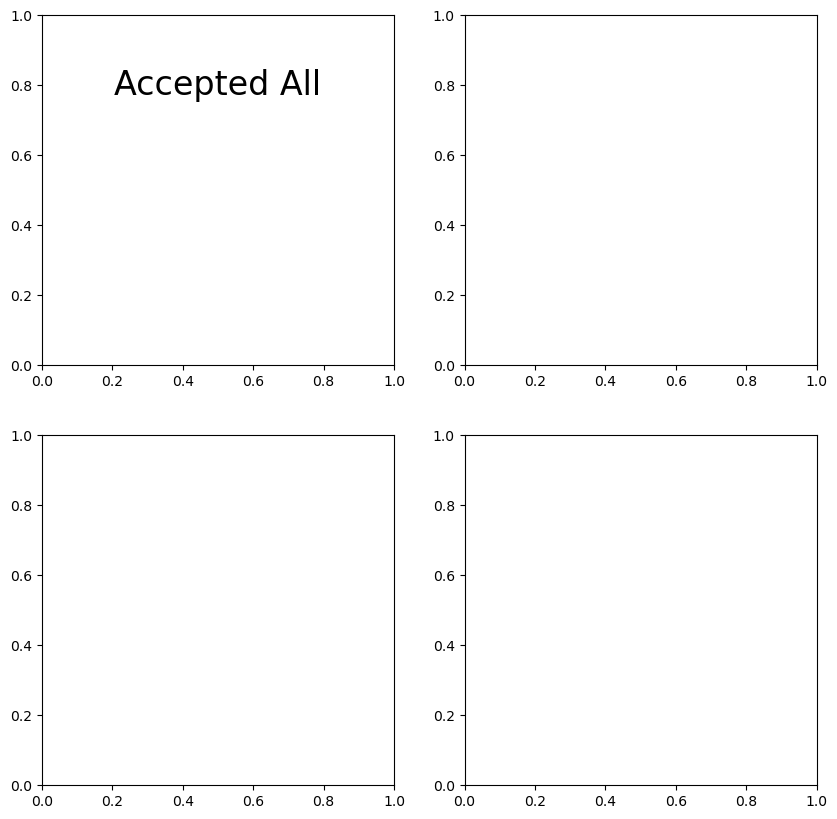

In [18]:
# Run the plots
scatter_svg(1,25)


In [ ]:
# A previous KDE plot that looked important:

# KDE rather than histogram version
# fig = plt.figure(figsize=(10,7))
# for regidx, reg in enumerate(percent_signif.columns):
# #     plt.subplot(2,3,regidx+1)
#     percent_signif[reg].plot.kde(bw_method=0.3, ind=50)
#  #   plt.title(reg)
# plt.xlabel("% of components with significant fit to regressors", fontsize=22, font='Baskerville')
# plt.xticks(font='Baskerville', fontsize=18)
# plt.yticks(font='Baskerville', fontsize=16)
# plt.ylabel("KDE density", fontsize=22, font='Baskerville')
# plt.legend(percent_signif.columns)
# plt.xlim([-1,101])
# plt.autoscale(enable=True, axis='y', tight=True)
# plt.savefig(f"{outdir}Regressor_Fit_Histograms.svg")